# Definición, tipologías y casos de uso de Graph Neural Networks para el aprendizaje basado en relaciones: presentación de implementación

## Introducción al notebook

Este documento de tipo notebook acompaña a la memoria del TFG con título *Definición, tipologías y casos de uso de Graph Neural Networks para el aprendizaje basado en relaciones*. El objetivo del documento es presentar la implementación de las pruebas realizadas con diferentes modelos de redes neuronales gráficas explicadas en el proyecto, así como plantear distintas aproximaciones para su codificación.

Aunque van a explicarse algunos conceptos relacionados con las librerías de Python utilizadas, se deja en manos de la memoria de proyecto el explicar la base teórica de los mismos, así como la evaluación e interpretación de los resultados obtenidos.

## Estructura del documento

Mediante el uso del orden presentado en la memoria, se van a repasar distintas aproximaciones a las GNN con dos planteamientos principales:

1. Clasificación de nodos dentro de un grafo:
    1. Implementación mediante un modelo con base espectral.
    1. Implementación con un modelo espacial mediante paso de mensajes.
    1. Contraste de resultados frente a un modelo tradicional que no tiene en cuenta la estructura de los datos, en busca de justificar la motivación de la existencia de las redes gráficas.
1. Predicción de enlazado.
    1. Implementación de un modelo que hace uso de paso de mensajes para predecir enlaces entre nodos.

Para cada uno de estos ejemplos se presentarán resultados de métricas de precisión durante el proceso de entrenamiento, para lo que se hará uso de datos de validación, así como pruebas finales sobre datos de test.

## Preparación del entorno

### Instalación de módulos

Como primer paso, se procede a instalar los módulos necesarios:

* [numpy](https://numpy.org/), para poder realizar las operaciones necesarias sobre los datos.
* [TensorFlow](https://www.tensorflow.org/), como librería principal para ejecutar los algoritmos de aprendizaje computacional del bloque de clasificación de nodos.
* [Spektral](https://graphneural.network/), una cómoda librería y colección de sets de datos que facilita el trabajo con redes neuronales gráficas.
* [PyTorch](https://pytorch.org/), librería de aprendizaje computacional que será usada para las pruebas de predicción de enlaces. Junto a ella se instalarán también algunas sublibrerías que serán necesarias.
* [tqdm](https://github.com/tqdm/tqdm), una librería simple para crear barras de progreso, con el simple objetivo de facilitar la lectura de algunas pruebas.
* [matplotlib](https://matplotlib.org/), con el fin de usarlo para representar gráficos comparativos.
* [sklearn](https://scikit-learn.org/stable/), librería `scikit-learn`, especializada en aprendizaje computacionao, que será utilizada como soporte para analizar algunos resultados.

A continuación, se hacen las llamadas oportunas para instalar las mismas en el entorno actual. De manera adicional, se adjunta el fichero `requirements.txt` junto con este notebook para su uso en caso de necesidad.

In [3]:
# Install required modules
necessary_modules = ['numpy', 'tensorflow', 'spektral', 'torch', 'torch-cluster', 'torch-scatter', 'torch-sparse', 'torch-geometric', 'tqdm', 'matplotlib', 'sklearn']
for module in necessary_modules:
    !pip install {module}

# Import numpy and TensorFlow modules, that is going to be use across the project
import numpy as np
import tensorflow as tf

A continuación, se establecen los valores de semilla aleatoria para numpy y TensorFlow, de modo que siempre que este notebook sea ejecutado se obtengan los mismos resultados.

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

### Configuración de TensorBoard

Tanto en los ejemplos donde se hace uso de TensorFlow como en aquellos implementados con PyTorch, se extraerán las métricas de aprendizaje y precisión a ficheros de registro que podrán ser leídos mediante [TensorBoard](https://www.tensorflow.org/tensorboard?hl=en), un entorno del propio TensorFlow que facilita su seguimiento y visualización. 

Para ello, es preciso preparar un directorio donde guardar el historial de registro de mensajes y configurar el propio entorno.

In [5]:
# Import TensorBoard callback to be able to use it in all the code samples
from keras.callbacks import TensorBoard

# Prepare placement for the logs
import os
root_logdir = os.path.join(os.curdir, 'my_logs')

# Create directory if it doesn't exists
from pathlib import Path
Path(root_logdir).mkdir(parents=True, exist_ok=True)

# Define a function that returns the path to store the log depending on the experiment
def get_run_logdir(experiment_name):
    import time
    run_id = time.strftime(f'run_{experiment_name}_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id) 

## Implementación de pruebas

A continuación se presentan las distintas pruebas realizadas.

### Pruebas de clasificación de nodos

Tal como se expone en la memoria de proyecto, las redes neuronales gráficas permiten, entre otras cosas, la clasificación de nodos en base a la información de sus vecindarios, lo que permite asignar clases dentro del contexto de las entidades de un grafo.

Para la realización de estas pruebas se hará uso de la librería Spektral, que ya ha sido instalada con anterioridad. Spektral ofrece una amplia colección de modelos de red neuronal gráfica ya implementados, así como distintas utilidades de código para su explotación. A modo de añadido, también incorpora una clase especial para poder cargar juegos de datos con distintas características, entre los que se encuentra CORA, que ha sido escogido para la realización de estas pruebas.

Así, el primer paso será importar el juego de datos y repasarlo, para lo que será preciso cargar la propia librería Spektral, así como TensorFlow y Keras, que pasan a sumarse a numpy, ya cargado, a la lista de módulos utilizados.

In [6]:
# Import necessary librearies and define aliases to refer to them easier
import spektral
from tensorflow import keras

# Set TensorFlow random seed to a fixed value to obtaine the same results
tf.random.set_seed(seed=42)

#### Carga y preparación del conjunto de datos

Como se indica en la memoria de proyecto, se hará uso del juego de datos conocido como CORA. Gracias a Spektral, es sencillo descargar este juego de datos y sus distintas estructuras ya preparadas.

In [7]:
# Download CORA dataset and its different members
from spektral.transforms import LayerPreprocess
from spektral.layers import GCNConv
dataset = spektral.datasets.citation.Citation(
    'cora', 
    random_split=False,
    normalize_x=True,
    transforms=[LayerPreprocess(GCNConv)],
    dtype=np.float32
    )

# Also load a list of labels as names, justo to be able to use it
label_names = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 
    'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']

Pre-processing node features


/Users/ghostmou/virtualenvs/uoc-tfg-gnn/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Tras esto, se pueden consultar las características del conjunto de datos que ha sido descargado.

In [8]:
print(f'Dataset: {dataset}')
print('First graph: {}'.format(dataset.graphs[0]))
print('Node labels: {}'.format(', '.join(label_names)))
print(f'Training samples: {np.sum(dataset.mask_tr)}')
print(f'Validation samples: {np.sum(dataset.mask_va)}')
print(f'Test samples: {np.sum(dataset.mask_te)}')

Dataset: Citation(n_graphs=1)
First graph: Graph(n_nodes=2708, n_node_features=1433, n_edge_features=None, n_labels=7)
Node labels: Case_Based, Genetic_Algorithms, Neural_Networks, Probabilistic_Methods, Reinforcement_Learning, Rule_Learning, Theory
Training samples: 140
Validation samples: 500
Test samples: 1000


Gracias a los datos extraídos, se puede ver que la variable `dataset` contiene un grafo, el cuál puede ser accedido para conocer sus características. De este modo, se comprueba que el conjunto de datos CORA ha sido descargado y está compuesto por:

* 2708 nodos o vértices, que conforman el grafo.
* 1433 atributos de nodo.
* 0 atributos de relación, es decir, los enlaces que relacionan los nodos no contienen información. Como se explica en la memoria de proyecto, esto impide tener distintas categorías en los vínculos y limitará el aprendizaje al contenido de los nodos y el contexto con el que se relacionan.
* 7 clases. En base a la definición del juego de datos, se sabe que los vértices se clasifican en dicho número de grupos. Sin embargo, como se explica en la memoria de proyecto, también es posible hacer uso de GNNs para clasificar grafos, por lo que Spektral nos permite trabajar con dos tipos de etiquetas: de nodo y de grafo.

Además, Spektral se encarga de generar los subconjuntos del juego de datos que son necesarios para las pruebas a realizar, que quedan divididos en tres:

* Conjunto de entrenamiento, que cuenta con 140 nodos. Es accesible desde `dataset.mask_tr`.
* Conjunto de validación, compuesto por 500 vértices. Puede recuperarse mediante `dataset.mask_va`.
* Conjunto de pruebas o *test*, formado por 1000 entidades. Se pueden computar desde `dataset.mask_te`.

Esta separación en conjuntos de entrenamiento, validación y test se hace mediante un enmascaramiento: están formados por un vector de tipo `narray` con tantas posiciones como nodos hay en el conjunto de datos. En cada posición se registrará un `1` si el vértice correspondiente pertenece al conjunto y con un `0` en caso contrario.

Por esta razón, se presenta la posibilidad de generar los pesos de cada vértice según si han sido seleccionados o no. Con el fin de fijar el mismo peso para todos dentro de cada conjunto, se procede a dividir cada uno de ellos por el número de observaciones en su grupo. El resultado es almacenado en `weighted_mask`.

In [9]:
weighted_mask = [
    mask.astype(np.float32) / np.count_nonzero(mask)
    for mask in (dataset.mask_tr, dataset.mask_va, dataset.mask_te)
]

print(f'Training samples weights: {np.nanmean(np.where(weighted_mask[0] > 0, weighted_mask[0],np.nan), 0)}')
print(f'Validation samples weights: {np.nanmean(np.where(weighted_mask[1] > 0, weighted_mask[1],np.nan), 0)}')
print(f'Test samples weights: {np.nanmean(np.where(weighted_mask[2] > 0, weighted_mask[2],np.nan), 0)}')

Training samples weights: 0.0071428571827709675
Validation samples weights: 0.0020000000949949026
Test samples weights: 0.0010000001639127731


Dentro del grafo registrado, es posible acceder a las diferentes estructuras que lo representan

In [10]:
print('Características de los nodos, en formato matriz:\n{}\n\n'.format(dataset.graphs[0].x))
print('Matriz de adyacencia, de tipo sparse matrix:\n{}\n\n'.format(dataset.graphs[0].a))

Características de los nodos, en formato matriz:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Matriz de adyacencia, de tipo sparse matrix:
  (0, 0)	0.25
  (0, 633)	0.25
  (0, 1862)	0.2236068
  (0, 2582)	0.25
  (1, 1)	0.25
  (1, 2)	0.20412415
  (1, 652)	0.28867513
  (1, 654)	0.35355338
  (2, 1)	0.20412415
  (2, 2)	0.16666667
  (2, 332)	0.16666667
  (2, 1454)	0.28867513
  (2, 1666)	0.15430336
  (2, 1986)	0.05025189
  (3, 3)	0.49999997
  (3, 2544)	0.49999997
  (4, 4)	0.16666667
  (4, 1016)	0.16666667
  (4, 1256)	0.13608277
  (4, 1761)	0.14433756
  (4, 2175)	0.16666667
  (4, 2176)	0.13608277
  (5, 5)	0.25
  (5, 1629)	0.25
  (5, 1659)	0.28867513
  :	:
  (2699, 2699)	0.49999997
  (2700, 1151)	0.40824828
  (2700, 2700)	0.49999997
  (2701, 44)	0.28867513
  (2701, 2624)	0.3333333
  (2701, 2701)	0.3333333
  (2702, 186)	0.21821788
  (2702, 1536)	0.2581989
  (2702, 2702)	0.3333333
  (27

In [11]:
print('Características de las aristas, en formato matriz (vacía, en este caso):\n{}\n\n'.format(dataset.graphs[0].e))
print('Etiquetas de cada nodo:\n{}'.format(dataset.graphs[0].y))

Características de las aristas, en formato matriz (vacía, en este caso):
None


Etiquetas de cada nodo:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Experimento 1: Implementación ConvGNN espectral

Gracias al fichero de datos preparado, es posible probar la implementación de uno de los modelos presentados en la memoria de proyecto: una red neuronal convolucional gráfica o ConvGNN con una aproximación espectral.

Como se explica en el documento de proyecto, el uso de la estructural espectral permite el aprendizaje y predicción en base a la estructura general del grafo, por lo que se hará uso de la matriz de adyacencia y las características de los nodos, pero sin la posibilidad de tener en cuenta la estructura general, algo que veremos en mayor detalle en la implementación de una ConvGNN espacial en el siguiente apartado.

El primer paso será cargar los datos en un `Loader`, una clase dentro de Spektral que se encarga de gestionar el conjunto de datos y devolver los subconjuntos necesarios para el entrenamiento de la red neuronal. Así, se procede a crear uno para el conjunto de entrenamiento y otro para el de validación. Puesto que el ejemplo está destinado a aprender de una única representación de grafo, se usará un `SingleLoader` y se le pasarán los pesos de los nodos, con el fin de tenerlos en cuenta en la salida.

In [12]:
from spektral.data.loaders import SingleLoader
loader_training = SingleLoader(dataset, sample_weights=weighted_mask[0])
loader_validation = SingleLoader(dataset, sample_weights=weighted_mask[1])

Durante la fase de entrenamiento, cada loader devolverá una tupla compuesta por una tupla que contendrá los inputs del modelo, las etiquetas de cada nodo y los pesos de los mismos desde la estructura pasada como `sample_weights`.

Con los datos listos para ser usados, el siguiente paso será crear el modelo desde Spektral. En este caso, se hará uso de la clase `GCN` de Spektral, la cuál hace uso de la arquitectura propuesta en el paper de Kipf y Welling de 2016 (**REFERENCIA** desde memoria). La instancia se crea mediante el paso de:

1. Número de etiquetas de nodo mediante `n_labels`, dato que se recoge desde el conjunto de datos creado.
1. Número de características de nodos mediante `n_input_channels`. Tal como se explica en la memoria, este modelo básico de red convolucional gráfica hace uso de las características de cada nodo y las relaciones de su entorno, pero no tiene en cuenta las propiedades de los enlaces entre vértices, por lo que estas son ignoradas como entrada.

Además, se pueden destacar algunas propiedades adicionales:

* Se fija un ritmo de aprendizaje de 0.01.
* Se elige la función de suma como método de agregación.
* Se utiliza el optimizador `Adam`.
* Se opta por *cross entropy* como función de pérdida.
* Se configura la métrica de precisión para su seguimiento.

In [13]:
from spektral.models.gcn import GCN # Import model
from tensorflow.keras.optimizers import Adam # Import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy # Import loss function from Keras

# Set initial configuration
learning_rate = 1e-2
reduction_function = 'sum'
optimizer = Adam(learning_rate=learning_rate)
loss_function = CategoricalCrossentropy(reduction=reduction_function)
metrics_to_evaluate = ['acc']

# Create model from Spektral
model_gcn = GCN(n_labels=dataset.n_labels, n_input_channels=dataset.n_node_features)

# Compile loaded model
model_gcn.compile(
    optimizer=optimizer, loss=loss_function, weighted_metrics=metrics_to_evaluate)

2021-12-29 11:36:46.884174: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Con el modelo listo, es posible proceder a llevar a cabo su entrenamiento. Con el fin de detener el proceso tan pronto como se detecte que la precisión no progresa, se hace uso del callback `EartlyStopping` de Keras con una paciencia de `10`, lo que establece que el proceso se detendrá si pasado dicho número de épocas (*epochs*) no se detecta una mejora en los resultados. De igual manera, se establece un máximo de `200` épocas de entrenamiento.

Para terminar, se añade un callback para enviar los resultados a TensorBoard.

In [14]:
# Eartly stopping settings
early_stopping_patience = 10
max_number_of_epochs = 400

# Fit the model
from tensorflow.keras.callbacks import EarlyStopping
model_gcn.fit(
    loader_training.load(),
    steps_per_epoch=loader_training.steps_per_epoch,
    validation_data=loader_validation.load(),
    validation_steps=loader_validation.steps_per_epoch,
    epochs=max_number_of_epochs,
    callbacks=[
        EarlyStopping(patience=early_stopping_patience,  restore_best_weights=True),
        TensorBoard(get_run_logdir('gcn_spectral'))
    ]
)

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 1.9541 - acc: 0.1071 - val_loss: 1.9512 - val_acc: 0.2660
Epoch 2/400
1/1 [==============================] - 0s 40ms/step - loss: 1.9482 - acc: 0.3071 - val_loss: 1.9482 - val_acc: 0.3800
Epoch 3/400
1/1 [==============================] - 0s 35ms/step - loss: 1.9422 - acc: 0.5571 - val_loss: 1.9451 - val_acc: 0.4020
Epoch 4/400
1/1 [==============================] - 0s 36ms/step - loss: 1.9372 - acc: 0.5571 - val_loss: 1.9420 - val_acc: 0.3980
Epoch 5/400
1/1 [==============================] - 0s 34ms/step - loss: 1.9288 - acc: 0.6143 - val_loss: 1.9391 - val_acc: 0.3760
Epoch 6/400
1/1 [==============================] - 0s 35ms/step - loss: 1.9188 - acc: 0.6571 - val_loss: 1.9366 - val_acc: 0.3380
Epoch 7/400
1/1 [==============================] - 0s 65ms/step - loss: 1.9119 - acc: 0.6143 - val_loss: 1.9343 - val_acc: 0.3140
Epoch 8/400
1/1 [==============================] - 0s 41ms/step - loss: 1.9054 - acc: 0.5500

Con el modelo ya entrenado, es posible evaluar su precisión frente al juego de datos de prueba.

In [15]:
loader_te = SingleLoader(dataset, sample_weights=weighted_mask[2])
results = model_gcn.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)

print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')

1/1 [==============================] - 0s 15ms/step - loss: 1.0007 - acc: 0.8090
Test loss: 1.0007295608520508
Test accuracy: 0.8090001940727234


In [16]:
# TODO Añadir número de referencia desde memoria cuando esté todo listo

#### Experimento 2: ConvGNN espacial mediante paso de mensajes: MPNN

En el ejemplo anterior se ha basado el aprendizaje y la clasificación en la estructura espectral de los datos cargados, es decir, en la estructura de la matriz de adyacencia. Sin embargo, tal y como se explica en la memoria de proyecto, esta aproximación puede ser pobre para escenarios donde las relaciones (aristas) entre entidades (vértices) del grafo tienen un significado o importancia diferente, o cuando el contexto de un nodo, construido mediante los atributos de sus vecinos, es importante para la clasificación.

Para poder preparar este ejemplo, se hará uso de la clase `MessagePassing` de Spektral, que ofrece una API ya preparada para configurar la función de activación y personalizar el comportamiento para distintos juegos de datos. Así, será preciso personalizar:

* Función para la construcción del mensaje pasado entre dos vértices vía la arista que los une. Es conocida como `message` dentro de la API de Spektral.
* Selección de la función de agregación de los mensajes pasados desde cada arista a cada nodo: suma, media, etc. Aparece definida como `aggregate`.

Puesto que las GNN basadas en paso de mensajes requieren sucesivas iteraciones que permitan propagar los mensajes a niveles cada vez más lejanos, la función `propagate` lo ejecuta y computa los atributos de cada nodo tras pasar los mensajes de todas las aristas del grafo y computar la correspondiente función de agregación.

Puesto que Spektral está construido sobre Keras, es preciso, además, implementar algunos de los métodos heredados de la clase `Layer` para definir la capa gráfica espacial:

* `__init__`, donde se define la función de activación, se pasan el resto de hiperparámetros estándar y se guarda el dato del tamaño de la salida, que será usado más adelante.
* `build`, cuya misión es la de inicializar los pesos de la capa mediante la llamada a `add_weight` y asignar el tamaño que tendrá la matriz utilizada para almacenar los pesos dentro de la capa. La matriz de pesos tendrá tantas filas como la entrada y columnas como la salida.
* `call` es el método encargado de ejecutar los cálculos de la capa. Puesto que estamos hablando de paso de mensajes, la salida de la capa será función de las característica de los nodos de entrada y los pesos de la capa. Al final de la misma, en lugar de llamar a la función de activación, se llama a `propagate`, un método disponible dentro de `MessagePassing` encargado de realizar la propagación de los mensajes de cada nodo a sus vecinos.

A estos métodos estándar, se incorporan otros de la propia API de Spektral, especializados en el trabajo con redes gráficas:

* `message`, encargado de componer el mensaje que será pasado entre los nodos. En este ejemplo se hace uso de la información de los nodos vecinos, accesibles mediante `get_j`.
* `aggregate`, con el cometido de definir la función de agregación para los mensajes del vecindario. Aquí se hace uso de la media de todos los mensajes del vecindario, aunque una posible mejora del modelo podría ser el uso de hiperparámetros para encontrar la que mejores reusltados pueda dar. Esta opción es posible desde el propio constructor.
* `update` donde, ahora sí, se hace uso de la función de activaciónn apra actualizar la matriz de pesos.

Con todo, se empieza creando la clase MPNNLayer como herencia `MessagePassing` para preparar la personalización de los citados métodos y definir la capa de paso de mensajes del modelo a usar.

In [17]:
from spektral.layers import MessagePassing

class MPNNLayer(MessagePassing):
    def __init__(self, n_out, activation, **kwargs):
        # Initialize message passing layer with the activation function chosen when creating the model
        super().__init__(activation=activation, **kwargs)
        self.n_out = n_out

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            shape=(batch_input_shape[0][-1], self.n_out)
        )

    def call(self, inputs):
        x, a = inputs

        # Update node features based on inputs by multiplying node attributes by 
        # the weights stored during build.
        # Kipf 2016
        x = tf.matmul(x, self.kernel)

        # Return propagation result
        return self.propagate(x=x, a=a)

    def message(self, x):
        return self.get_j(x)
    
    def aggregate(self, messages): 
        # We need to return the result of applying the aggregate function over the messages

        # Try to use the mean as aggregate function. We use a scatter mean method for this experiment:
        return spektral.layers.ops.scatter_mean(messages, self.index_i, self.n_nodes)

    def update(self, embeddings):
        return self.activation(embeddings)


Creada la capa, podemos hacer uso de la misma creando un modelo mediante la API funcional de Keras. Para ello, se empieza por configurar algunos parámetros básicos para su funcionamiento:

* Ratio de regularización (o *regularization rate*): con el fin de regularizar los contenidos. Se inicia con un valor de `5e-6`.
* Ratio de aprendizaje (o *learning rate*) con un valor de 0.2.
* Número de epochs de entrenamiento, que son fijadas en 20.
* Nivel de paciencia para el early stopping que será usado más abajo en la etapa de entrenamiento.

Hecho esto, se extran las características principales de los datos: número de nodos, número de careacterísticas por nodo y número de clases para clasificarlos. Estos datos serán usados para instanciar la capa de paso de mensajes.

In [18]:
# Initial setup for the model
l2_regularization_rate = 5e-6
learning_rate = 0.2
epochs = 400
patience = 10

# Input parameters
number_of_nodes = dataset.n_nodes
number_of_node_features = dataset.n_node_features
number_of_labels = dataset.n_labels

Ahora es el momento de definir las entradas. Para ello, se crearán dos tensores:

* `adjacency_matrix` con la matriz de adyacencia, que contendrá la matriz de adyacencia y que permitirá saber las conexiones de cada nodo.
* `x_input` con las características de cada nodo.

Ambas son usadas para definir la capa de salida del modelo, que será construida mediante la clase definida para el MPNNLayer.

In [19]:

# Define input tensors
# We define two input tensors: one for the nodes and one for the adjacency matrix
from keras.layers import Input
adjacency_input = Input(
    (number_of_nodes,), sparse=True, dtype=dataset[0].a.dtype,
    name='adjacency_matrix_input'
)
x_input = Input(
    shape=(number_of_node_features,),
    name='nodes_input'
)

In [20]:
# Define output layer based on the MPNN layer defined previously as MPNNLayer
mpnn_output_layer = MPNNLayer(
    number_of_labels, activation=keras.activations.softmax,
    kernel_regularizer=keras.regularizers.l2(l2_regularization_rate),
    use_bias=False, name='mpnn_layer'
)([x_input, adjacency_input])

In [21]:
# Build and compile model
from keras.models import Model
model_mpnn = Model(
    name='mpnn_gcn',
    inputs=[x_input, adjacency_input],
    outputs=mpnn_output_layer
)
model_mpnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
    loss=loss_function,
    weighted_metrics=['acc']
)
model_mpnn.summary()

Model: "mpnn_gcn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nodes_input (InputLayer)       [(None, 1433)]       0           []                               
                                                                                                  
 adjacency_matrix_input (InputL  [(None, 2708)]      0           []                               
 ayer)                                                                                            
                                                                                                  
 mpnn_layer (MPNNLayer)         (None, 7)            10031       ['nodes_input[0][0]',            
                                                                  'adjacency_matrix_input[0][0]'] 
                                                                                           

In [22]:
# Train the model
loader_tr = SingleLoader(dataset, sample_weights=weighted_mask[0])
loader_va = SingleLoader(dataset, sample_weights=weighted_mask[1])
model_mpnn.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[
        EarlyStopping(patience=patience, restore_best_weights=True),
        TensorBoard(get_run_logdir('gcn_spatial'))
    ],
)

Epoch 1/400
1/1 [==============================] - 1s 502ms/step - loss: 1.9466 - acc: 0.1143 - val_loss: 1.8721 - val_acc: 0.7020
Epoch 2/400
1/1 [==============================] - 0s 23ms/step - loss: 1.7838 - acc: 0.9929 - val_loss: 1.7995 - val_acc: 0.7040
Epoch 3/400
1/1 [==============================] - 0s 25ms/step - loss: 1.6265 - acc: 0.9929 - val_loss: 1.7294 - val_acc: 0.7100
Epoch 4/400
1/1 [==============================] - 0s 33ms/step - loss: 1.4764 - acc: 0.9929 - val_loss: 1.6620 - val_acc: 0.7160
Epoch 5/400
1/1 [==============================] - 0s 32ms/step - loss: 1.3345 - acc: 0.9929 - val_loss: 1.5976 - val_acc: 0.7200
Epoch 6/400
1/1 [==============================] - 0s 29ms/step - loss: 1.2017 - acc: 0.9929 - val_loss: 1.5363 - val_acc: 0.7260
Epoch 7/400
1/1 [==============================] - 0s 28ms/step - loss: 1.0786 - acc: 0.9929 - val_loss: 1.4782 - val_acc: 0.7300
Epoch 8/400
1/1 [==============================] - 0s 30ms/step - loss: 0.9656 - acc: 0.9

Una vez entrenado el modelo, se puede evaluar contra el conjunto de prueba.

In [23]:
loader_te = SingleLoader(dataset, sample_weights=weighted_mask[2])
results = model_mpnn.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)

print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')

1/1 [==============================] - 0s 16ms/step - loss: 0.8307 - acc: 0.7490
Test loss: 0.8307310938835144
Test accuracy: 0.7490002512931824


#### Experimento 3: clasificación de nodos mediante información de nodos

En este caso, en lugar de utilizar la información estrutural del grafo, se hará uso solo de las características de los nodos.

El primer paso será construir una estructura de datos que nos permita trabajar con un modelo que no esté diseñado para operar sobre grafos. Para ello, se extraerán las características de cada observación de los datos de origen y no se usarán sus enlaces. Con todo, el objetivo es medir el nivel de precisión a la hora de clasificar sin utilizar la estructura generado mediante las relaciones entre nodos.

In [52]:
# Extract train, validation and test features and labels
X_train = dataset[0].x[np.array(dataset.mask_tr)]
y_train = dataset[0].y[np.array(dataset.mask_tr)]
X_validation = dataset[0].x[np.array(dataset.mask_va)]
y_validation = dataset[0].y[np.array(dataset.mask_va)]
X_test = dataset[0].x[np.array(dataset.mask_te)]
y_test = dataset[0].y[np.array(dataset.mask_te)]

print(f'Training: X {X_train.shape}, y {y_train.shape}, from a source of {np.sum(dataset.mask_tr)} samples')
print(f'Validation: X {X_validation.shape}, y {y_validation.shape}, from a source of {np.sum(dataset.mask_va)} samples')
print(f'Test: X {X_test.shape}, y {y_test.shape}, from a source of {np.sum(dataset.mask_te)} samples')


Training: X (140, 1433), y (140, 7), from a source of 140 samples
Validation: X (500, 1433), y (500, 7), from a source of 500 samples
Test: X (1000, 1433), y (1000, 7), from a source of 1000 samples


Se han obtenido los diferentes subconjuntos de datos:

* Conjunto de entrenamiento, formado por las observaciones `X_train` y las categorías de cada una de ellas, `y_train`.
* Conjunto de validación, formado por las observaciones `X_validation` y las categorías de cada una de ellas, `y_validation`.
* Conjunto de pruebas, formado por las observaciones `X_test` y las categorías de cada una de ellas, `y_test`.


In [53]:
sequential_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train[0].shape, name='nodes_input'),
    keras.layers.Dense(100, activation=keras.activations.relu, name='hidden_dense'),
    keras.layers.Dense(7, activation=keras.activations.relu, name='output')
], name='non_gnn')
sequential_model.summary()

Model: "non_gnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 nodes_input (Flatten)       (None, 1433)              0         
                                                                 
 hidden_dense (Dense)        (None, 100)               143400    
                                                                 
 output (Dense)              (None, 7)                 707       
                                                                 
Total params: 144,107
Trainable params: 144,107
Non-trainable params: 0
_________________________________________________________________


Tras la definición, se puede pasar a compilar y entrenar el modelo.

In [56]:
sequential_model.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(reduction=reduction_function), # Loss function to be used.
    weighted_metrics=['acc']
)

sequential_model_history = sequential_model.fit(
    X_train, y_train, epochs=30, 
    validation_data=(X_validation, y_validation),
    callbacks=[
        EarlyStopping(patience=20,  restore_best_weights=True, monitor='val_loss', mode='min'), # Early stopping callback
        TensorBoard(get_run_logdir('non_gnn'))
    ]
)

Epoch 1/30
5/5 [==============================] - 1s 56ms/step - loss: nan - acc: 0.4714 - val_loss: nan - val_acc: 0.1220
Epoch 2/30
5/5 [==============================] - 0s 18ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1220
Epoch 3/30
5/5 [==============================] - 0s 16ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1220
Epoch 4/30
5/5 [==============================] - 0s 29ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1220
Epoch 5/30
5/5 [==============================] - 0s 29ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1220
Epoch 6/30
5/5 [==============================] - 0s 19ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1220
Epoch 7/30
5/5 [==============================] - 0s 21ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1220
Epoch 8/30
5/5 [==============================] - 0s 29ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1220
Epoch 9/30
5/5 [

In [57]:
results = sequential_model.evaluate(X_test, y_test, batch_size=42)

print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')

24/24 [==============================] - 0s 2ms/step - loss: nan - acc: 0.1300
Test loss: nan
Test accuracy: 0.12999999523162842


Como se puede comprobar, la precisión obtenida es muy baja. A continuación, se estudia la distribución de los errores de clasificación mediante la matriz de confusión, con el objetivo de identificar aquellas clases que se clasifican de manera incorrecta.

Classification report
                        precision    recall  f1-score   support

            Case_Based       0.17      0.45      0.24       130
    Genetic_Algorithms       0.38      0.27      0.32        91
       Neural_Networks       0.49      0.29      0.37       144
 Probabilistic_Methods       0.38      0.45      0.41       319
Reinforcement_Learning       0.31      0.21      0.25       149
         Rule_Learning       0.00      0.00      0.00       103
                Theory       0.29      0.08      0.12        64

              accuracy                           0.30      1000
             macro avg       0.29      0.25      0.24      1000
          weighted avg       0.31      0.30      0.29      1000



/Users/ghostmou/virtualenvs/uoc-tfg-gnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ghostmou/virtualenvs/uoc-tfg-gnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ghostmou/virtualenvs/uoc-tfg-gnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

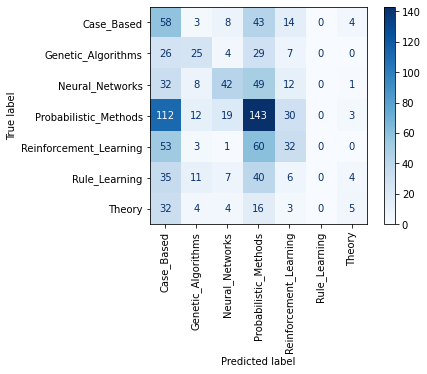

In [45]:
# Get predictions for the test set
predictions = sequential_model.predict(X_test)
y_predictions_values = np.argmax(predictions, axis=1)
y_test_values = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_test_values, y_predictions_values, target_names=label_names)
print('Classification report')
print('=====================')
print(report)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test_values, y_predictions_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

#### Experimento 4: predicción de enlaces

En lugar de utilizar TensorFlow con Keras y Spektral, el bloque relativo a predicción de enlaces se plantea mediante PyTorch Geometric, una librería basada en PyTorch que facilita el trabajo con redes neuronales gráficas.

El primer paso será, por supuesto, importar los módulos necesarios. Además, se configura el tipo de dispositivo como `cpu` dentro de PyTorch, pues esta librería permite también optimizar la ejecución mediante CUDA.

In [29]:
import torch
from torch.nn import Linear, Parameter,Embedding
import torch.nn.functional as F
from torch_scatter import scatter_mean, scatter, scatter_add, scatter_max
from torch_geometric.nn.conv import MessagePassing
import torch.nn as nn
from torch_geometric.utils import softmax
from torch_geometric.nn import GCNConv 
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

El ejemplo va a ser planteado mediante el algoritmo WalkPooling planteado por Liming Pan, Cheng Shi e Ivan Dokmanić en su paper [Neural Link Prediction with Walk Pooling](https://arxiv.org/abs/2110.04375). Por lo tanto, el primer paso será descargar el mismo desde su repositorio e importarlo en el entorno de este notebook.

In [30]:
# TODO Añadir número de referencia de memoria cuando tengamos todo maquetado

In [31]:
import os
import sys
notebook_directory = os.getcwd()
if notebook_directory not in sys.path:
    sys.path.append(notebook_directory)

# Clone WalkPooling algorithm
nb_dir_walkpooling = os.path.join(notebook_directory, 'WalkPooling')


In [32]:
if not os.path.isdir(nb_dir_walkpooling):
    !git clone https://github.com/DaDaCheng/WalkPooling/ {nb_dir_walkpooling}
else:
    print('WalkPooling repository already cloned in notebook directory')

WalkPooling repository already cloned in notebook directory


En este punto, el repositorio con los módulos basados en WalkPooling se ha clonado en el directorio local del notebook, por lo que es posible importar su código para las pruebas.

In [33]:
# Import WalkPooling module classes to implement the algorithm
from WalkPooling.src.model import LinkPred, WalkPooling, MLP

Mediante los módulos descargados, es posible también hacer uso del conjunto de datos CORA, por lo que se configura el código para ello. Además, se establecen algunas variables de configuración importantes:

* `walk_length`, que indica cuántos enlaces seguirá el algoritmo durante su proceso de aprendizaje. En este caso, se ha decidido hacer uso de un valor de `2`, que es el propuesto por el artículo original.
* `use_mse` desactiva el uso de MSE para estimar la pérdida, aunque se podría considerar hacer pruebas mediante `GridSearch` para comprobar si puede aportar una mejora en los resultados con este u otros conjuntos de datos.

Por otro lado, se podrían configuran los ratios del conjunto de datos que serán dedicados a validación y pruebas con los mismos valores que en anteriores pruebas. De hecho, se cargan estos ratios para su posible uso. Sin embargo, se aplicarán los ratios existentes en el artículo para poder reproducir sus resultados con mayor eficacia, situados en un 20% tanto para los subconjuntos de validación como de test.

In [34]:
# Link prediction message passing model settings
number_of_heads_in_attention_link_encoder = 2
walk_length = 2 # Number of learning iterations based on messages passing, called "walk length" (#TODO referenciar paper)
use_mse = False
practical_neg_sample = False

# Copy validation and test ratios from experiments performed using Spektral
val_ratio = np.sum(dataset.mask_va)/number_of_nodes
test_ratio = np.sum(dataset.mask_tr)/number_of_nodes

# Prompt settings to notebook
print(f'Validation ratio: {val_ratio}')
print(f'Test ratio: {test_ratio}')


Validation ratio: 0.18463810930576072
Test ratio: 0.051698670605613


Dado que el código original está planteado para ser ejecutado desde consola y no desde un notebook, se crea un diccionario que contendrá los parámetros por defecto que se esperarían dentro del código presentado en el repositorio de WalkPooling.

In [35]:

class MyDict(dict):
    pass

args = MyDict()
args.data_name = 'cora'
args.seed = 1
args.use_splitted = False
args.practical_neg_sample = True
args.observe_val_and_injection = False
args.init_attribute=None
args.lr = 0.0005 # learning rate
args.val_ratio = 0.2
args.test_ratio = 0.2
args.init_representation = None
args.num_hops = 3
args.max_nodes_per_hop = 100
args.drnl = False
args.batch_size = 32
args.weight_decay = 0
args.epoch_num = 10

Como en los casos anteriores, es necesario preparar los datos del conjunto elegido. En este caso, se vuelven a descargar mediante `prepare_data`, ofrecido desde el código del repositorio descargado, el cuál ya está dispuesto para poder ser usado para la predicción de enlaces.

In [36]:
# Prepare data
from WalkPooling.src.utils import prepare_data
train_loader, val_loader, test_loader, feature_results = prepare_data(args)

Using data: cora
Train_link: 6336  Val_link: 2110  Test_link: 2110


Los datos descargados ya están contenidos dentro de loaders de datos, los cuáles permiten recuperar la información de los subgrados por lotes, algo necesario para llevar a cabo el proceso de aprendizaje. Es posible examinar, además, los contenidos del conjunto de datos. 

Como se puede comprobar, está dispuesto mediante colecciones de subgrafos, tal y como plantea el artículo original, que serán usados durante el proceso de aprendizaje.

In [37]:
train_loader.dataset

[Data(x=[168, 1433], edge_index=[2, 440], z=0, edge_mask=[440], label=1.0),
 Data(x=[159, 1433], edge_index=[2, 388], z=0, edge_mask=[388], label=1.0),
 Data(x=[16, 1433], edge_index=[2, 34], z=0, edge_mask=[34], label=1.0),
 Data(x=[39, 1433], edge_index=[2, 96], z=0, edge_mask=[96], label=1.0),
 Data(x=[28, 1433], edge_index=[2, 74], z=0, edge_mask=[74], label=1.0),
 Data(x=[125, 1433], edge_index=[2, 350], z=0, edge_mask=[350], label=1.0),
 Data(x=[122, 1433], edge_index=[2, 364], z=0, edge_mask=[364], label=1.0),
 Data(x=[36, 1433], edge_index=[2, 80], z=0, edge_mask=[80], label=1.0),
 Data(x=[10, 1433], edge_index=[2, 20], z=0, edge_mask=[20], label=1.0),
 Data(x=[3, 1433], edge_index=[2, 4], z=0, edge_mask=[4], label=1.0),
 Data(x=[21, 1433], edge_index=[2, 52], z=0, edge_mask=[52], label=1.0),
 Data(x=[121, 1433], edge_index=[2, 322], z=0, edge_mask=[322], label=1.0),
 Data(x=[119, 1433], edge_index=[2, 272], z=0, edge_mask=[272], label=1.0),
 Data(x=[221, 1433], edge_index=[2, 

Llegados a este punto, se procede a instanciar el modelo desde la clase `LinkPred` del repositorio, la cuál hereda de la clase `MessagePassing` ofrecida por PyTorch Geometric y que, como su nombre indica, está planteada para soportar algoritmos de paso de mensajes dentro de redes geométricas. A modo de añadido, se selecciona como optimizador el algoritmo `Adam`, como en anteriores experimentos, y se opta por la función de pérdida `MSE` con reducción mediante la media (`mean`).

In [38]:
# Instance LinkPred model
model = LinkPred(
    in_channels=number_of_node_features, # Number of nodes used as input data
    hidden_channels=number_of_labels, # Number of labels used as output data
    heads=number_of_heads_in_attention_link_encoder, # Number of attention heads
    walk_len=walk_length, 
    MSE=use_mse
).to(device)

# Select optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = torch.nn.MSELoss(reduction='mean')

Antes de poder proceder con la ejecución del entrenamiento y evaluación, es preciso crear dos funciones de soporte que permitan su uso sobre los conjuntos de datos que han sido separados.

In [39]:
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm

def train(loader,epoch):
    model.train()
    loss_epoch=0
    for data in tqdm(loader,desc="train"):  # Iterate in batches over the training dataset.
        data = data.to(device)
        label= data.label
        out = model(data.x, data.edge_index, data.edge_mask, data.batch, data.z)
        torch.cuda.empty_cache()
        loss = criterion(out.view(-1), label)  
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()
        loss_epoch=loss_epoch+loss.item()
    return loss_epoch/len(loader)


def test(loader,data_type='test'):
    model.eval()
    scores = torch.tensor([])
    labels = torch.tensor([])
    loss_total=0
    with torch.no_grad():
        for data in tqdm(loader,desc='test:'+data_type):  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_mask, data.batch, data.z)
            loss = criterion(out.view(-1), data.label)
            out = out.cpu().clone().detach()
            scores = torch.cat((scores,out),dim = 0)
            labels = torch.cat((labels,data.label.view(-1,1).cpu().clone().detach()),dim = 0)
        scores = scores.cpu().clone().detach().numpy()
        labels = labels.cpu().clone().detach().numpy()
        loss_total=loss_total+loss.item()
        return roc_auc_score(labels, scores), average_precision_score(labels, scores),loss_total

Así, el modelo está listo para ser entrenado. Como en anteriores experimentos, se incorpora TensorBoard para poder extraer métricas que nos permitan estudiar su éxito.

In [40]:
# Prepare TensorBoard to receive data from this training
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter(log_dir=get_run_logdir('mpnn_walkpooling'))

# Store key scores during training
Best_Val_fromloss = 1e10
Final_Test_AUC_fromloss = 0
Final_Test_AP_fromloss = 0

Best_Val_fromAUC = 0
Final_Test_AUC_fromAUC = 0
Final_Test_AP_fromAUC = 0

# Iterate each epoch to train the model. Send performance metrics to TensorBoard
for epoch in range(1, args.epoch_num + 1):
    epoch_loss = train(train_loader, epoch)
    val_auc, val_ap, val_loss = test(val_loader,data_type='val')
    test_auc,test_ap, test_loss = test(test_loader,data_type='test')

    if val_loss < Best_Val_fromloss:
        Best_Val_fromloss = val_loss
        Final_Test_AUC_fromloss = test_auc
        Final_Test_AP_fromloss = test_ap

    if val_auc > Best_Val_fromAUC:
        Best_Val_fromAUC = val_auc
        Final_Test_AUC_fromAUC = test_auc
        Final_Test_AP_fromAUC = test_ap

    # Log performance metrics into TensorBoard
    tb.add_scalar('epoch_loss', epoch_loss, epoch) # Log epoch loss
    # tb.add_scalar('epoch_acc', val_ap, epoch) # Log epoch accuracy
    tb.add_scalar('validation_loss', val_loss, epoch) # Log epoch validation loss
    tb.add_scalar('validation_acc', val_ap, epoch) # Log epoch validation accuracy
    tb.add_scalar('test_loss', test_loss, epoch) # Log test loss
    tb.add_scalar('test_acc', test_ap, epoch) # Log test accuracy

    # Prompt to notebook
    print(f'Epoch: {epoch}/{args.epoch_num}\t Loss: {epoch_loss:.4f}\nValidation accuracy: {val_ap:.4f}\tValidation loss: {val_loss:.4f}\nTest accuracy: {test_ap:.4f}\tTest loss: {test_loss:.4f}')

print(f'From loss: Final Test AUC: {Final_Test_AUC_fromloss:.4f}, Final Test AP: {Final_Test_AP_fromloss:.4f}')
print(f'From AUC: Final Test AUC: {Final_Test_AUC_fromAUC:.4f}, Final Test AP: {Final_Test_AP_fromAUC:.4f}')

train:  52%|█████▏    | 103/198 [00:37<00:34,  2.72it/s]


KeyboardInterrupt: 

In [ ]:
print(f'Best validation accuracy: {Best_Val_fromAUC}')
print(f'Best validation loss: {Best_Val_fromloss}')